# SciANN-NN-Regression.py

An illustrain to use SciANN for curve-fitting using artificial neural networks.

For additional details, please check our paper at: https://arxiv.org/abs/2005.08803 
    
Created by Ehsan Haghighat on 5/01/20.

In [1]:
# You need to have tensorflow, keras, and sciann installed in your system. 
# On google cloud, uncomment next line to install sciann. 

# !pip install sciann 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import sciann as sn 

Using TensorFlow backend.


---------------------- SCIANN 0.4.5.2 ---------------------- 
For details, check the review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



# Introduction

The objective is to use sciann for curve-fitting using neural networks. 

Let us assume that we have a "synthetic" dataset generated from: 
$$
f(x) = \sin(x) sin(y)
$$

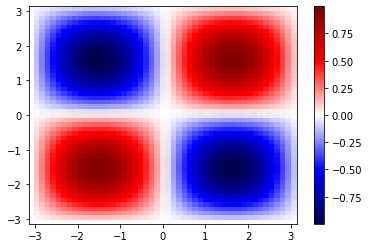

In [3]:
x_data, y_data = np.meshgrid(
    np.linspace(-np.pi, np.pi, 50), 
    np.linspace(-np.pi, np.pi, 50)
)
f_data = np.sin(x_data) * np.sin(y_data)
plt.pcolor(x_data, y_data, f_data, cmap='seismic')
plt.colorbar()

## Step 1: Setting up the neural network

The first step is to set up the approximation function in the form of a neural network. 

This is done in sciann as follows:

In [4]:
x = sn.Variable('x')
y = sn.Variable('y')
f = sn.Functional('f', [x, y], [10, 10, 10, 10], 'tanh')

Once the network is defined, you can evaluate its initial state as:

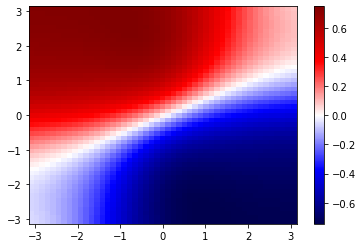

In [5]:
f_pred = f.eval([x_data, y_data])
im = plt.pcolor(x_data, y_data, f_pred, cmap='seismic')
plt.colorbar(im)

As you find, the initial state of the network is far from the exptected values. 

## Step 2: Setting up the optimization model 

The second step is to set up the optimization model, i.e. the set of inputs and targets. 

This is done using the SciModel interface as: 

In [6]:
d1 = sn.Data(f)
m = sn.SciModel([x, y], d1)

You can obtain a summary of the network architecture as:

In [7]:
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
y (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
conct_1 (Concatenate)           (None, 2)            0           x[0][0]                          
                                                                 y[0][0]                          
__________________________________________________________________________________________________
D10b_1 (Dense)                  (None, 10)           30          conct_1[0][0]              

You can now train the model using ".train" function: 

In [8]:
h = m.train([x_data, y_data], f_data, learning_rate=0.002, epochs=500, verbose=0)


Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00313: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00412: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


The training history can be visualized as: 

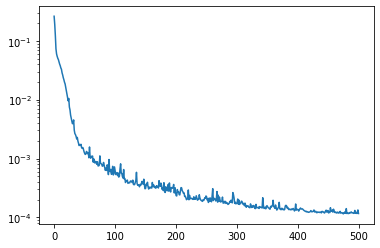

In [9]:
plt.semilogy(h.history['loss'])

We can now test the trained network in $x, y \in [-2\pi, 2\pi]$ as:

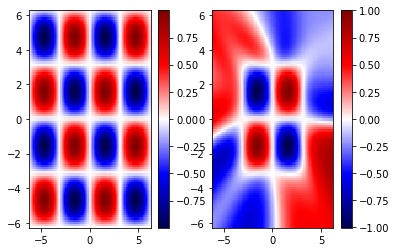

In [10]:
x_test, y_test = np.meshgrid(np.linspace(-2*np.pi, 2*np.pi, 100), np.linspace(-2*np.pi, 2*np.pi, 100))
f_test = np.sin(x_test) * np.sin(y_test)

f_pred = f.eval([x_test, y_test])

fig, ax = plt.subplots(1, 2)

im = ax[0].pcolor(x_test, y_test, f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolor(x_test, y_test, f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])

# Physics-informed deep learning

Note that the function $f(x,y) = \sin(x)\sin(y)$ satisfies the following PDE:
$$
f_{,xx} + f_{,yy} + 2f = 0
$$

We can incorporate this PDE into the loss function as follows: 

## Step 1: defining the network

In [11]:
x = sn.Variable('x')
y = sn.Variable('y')
f = sn.Functional('f', [x, y], [10, 10, 10, 10], 'tanh')

## Step 2: defining the objectives functions and optimization model 

In [12]:
f_xx = sn.math.diff(f, x, order=2)
f_yy = sn.math.diff(f, y, order=2)
L = f_xx + f_yy + 2*f

In [13]:
d1 = sn.Data(f)
d2 = sn.Data(L)
m = sn.SciModel([x, y], [d1, d2])
h = m.train([x_data, y_data], [f_data, 'zero'], learning_rate=0.002, epochs=500, verbose=0)


Epoch 00361: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 00460: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


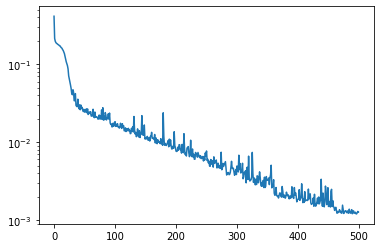

In [14]:
plt.semilogy(h.history['loss'])

The new results can be evaluated as:

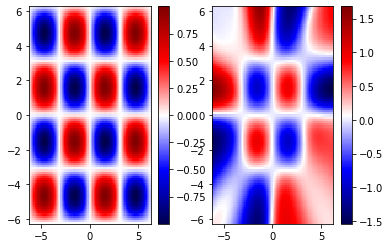

In [15]:
x_test, y_test = np.meshgrid(np.linspace(-2*np.pi, 2*np.pi, 100), np.linspace(-2*np.pi, 2*np.pi, 100))
f_test = np.sin(x_test) * np.sin(y_test)

f_pred = f.eval([x_test, y_test])

fig, ax = plt.subplots(1, 2)

im = ax[0].pcolor(x_test, y_test, f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolor(x_test, y_test, f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])

As you find, the PINN model has higher accuracy and predictive capabilities compared to the data-driven model. 